In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter("[%(levelname)s] %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import json
import os
import pprint
import sys
import warnings

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

warnings.filterwarnings('ignore')

if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess

[INFO] set ART_DATA_PATH to /root/.art/data


In [3]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)


n_train = np.shape(x_raw)[0]
num_selection = 7500
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

BACKDOOR_TYPE = "pattern"

In [4]:
max_val = np.max(x_raw)
def add_modification(x):
    if BACKDOOR_TYPE == 'pattern':
        return add_pattern_bd(x, pixel_value=max_val)
    elif BACKDOOR_TYPE == 'pixel':
        return add_single_bd(x, pixel_value=max_val) 
    
    else:
        raise("Unknown backdoor type")

In [5]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources=np.arange(10)
    targets=(np.arange(10) + 1) % 10 
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

In [6]:
percent_poison = 0.33
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(x_raw, y_raw, percent_poison, add_modification)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)

x_train = np.expand_dims(x_train, axis=3)


(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(x_raw_test, y_raw_test, percent_poison, add_modification)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)

x_test = np.expand_dims(x_test, axis=3)

n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]
is_poison_train = is_poison_train[shuffled_indices]

In [7]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

[WARNING] From /root/anaconda3/envs/exp1/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [8]:
classifier = KerasClassifier(model=model, clip_values=(min_, max_))
classifier.fit(x_train, y_train, nb_epochs=10, batch_size=128)

[INFO] Inferred 7 hidden layers on Keras classifier.


Epoch 1/10
87/87 [==============================] - 12s 139ms/step - loss: 1.2954 - acc: 0.5330
Epoch 2/10
87/87 [==============================] - 12s 135ms/step - loss: 0.4868 - acc: 0.8479
Epoch 3/10
87/87 [==============================] - 12s 133ms/step - loss: 0.2753 - acc: 0.9156
Epoch 4/10
87/87 [==============================] - 12s 136ms/step - loss: 0.2064 - acc: 0.9390
Epoch 5/10
87/87 [==============================] - 12s 136ms/step - loss: 0.1686 - acc: 0.9478
Epoch 6/10
87/87 [==============================] - 12s 133ms/step - loss: 0.1365 - acc: 0.9582
Epoch 7/10
87/87 [==============================] - 11s 132ms/step - loss: 0.1104 - acc: 0.9635
Epoch 8/10
87/87 [==============================] - 11s 132ms/step - loss: 0.1012 - acc: 0.9690
Epoch 9/10
87/87 [==============================] - 12s 136ms/step - loss: 0.0897 - acc: 0.9725
Epoch 10/10
87/87 [==============================] - 12s 135ms/step - loss: 0.0829 - acc: 0.9721



Clean test set accuracy: 97.77%


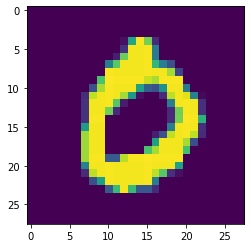

Prediction: 0


In [9]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))


c = 0 
i = 0 

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i]

plt.imshow(clean_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

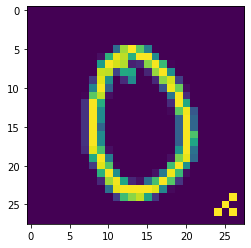

Prediction: 1

 Effectiveness of poison: 96.83%


In [10]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]



c = 1 
i = 0

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] 

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))

In [11]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import os
import pickle
import time
from typing import Any, Dict, List, Optional, Tuple, TYPE_CHECKING

import numpy as np

from sklearn.cluster import KMeans, MiniBatchKMeans

from art import config
from art.data_generators import DataGenerator
from art.defences.detector.poison.clustering_analyzer import ClusteringAnalyzer
from art.defences.detector.poison.ground_truth_evaluator import GroundTruthEvaluator
from art.defences.detector.poison.poison_filtering_defence import PoisonFilteringDefence
from art.utils import segment_by_class
from art.visualization import create_sprite, save_image, plot_3d

if TYPE_CHECKING:
    from art.utils import CLASSIFIER_NEURALNETWORK_TYPE

logger = logging.getLogger(__name__)


class ActivationDefence(PoisonFilteringDefence):


    defence_params = [
        "nb_clusters",
        "clustering_method",
        "nb_dims",
        "reduce",
        "cluster_analysis",
        "generator",
        "ex_re_threshold",
    ]
    valid_clustering = ["KMeans"]
    valid_reduce = ["PCA", "FastICA", "TSNE"]
    valid_analysis = ["smaller", "distance", "relative-size", "silhouette-scores"]

    TOO_SMALL_ACTIVATIONS = 32  
    def __init__(
        self,
        classifier: "CLASSIFIER_NEURALNETWORK_TYPE",
        x_train: np.ndarray,
        y_train: np.ndarray,
        generator: Optional[DataGenerator] = None,
        ex_re_threshold: Optional[float] = None,
    ) -> None:
        """
        Create an :class:`.ActivationDefence` object with the provided classifier.
        :param classifier: Model evaluated for poison.
        :param x_train: A dataset used to train the classifier.
        :param y_train: Labels used to train the classifier.
        :param generator: A data generator to be used instead of `x_train` and `y_train`.
        :param ex_re_threshold: Set to a positive value to enable exclusionary reclassification
        """
        super().__init__(classifier, x_train, y_train)
        self.classifier: "CLASSIFIER_NEURALNETWORK_TYPE" = classifier
        self.nb_clusters = 2
        self.clustering_method = "KMeans"
        self.nb_dims = 10
        self.reduce = "PCA"
        self.cluster_analysis = "smaller"
        self.generator = generator
        self.activations_by_class: List[np.ndarray] = []
        self.clusters_by_class: List[np.ndarray] = []
        self.assigned_clean_by_class: np.ndarray
        self.is_clean_by_class: List[np.ndarray] = []
        self.errors_by_class: np.ndarray
        self.red_activations_by_class: List[np.ndarray] = []  
        self.evaluator = GroundTruthEvaluator()
        self.is_clean_lst: List[int] = []
        self.confidence_level: List[float] = []
        self.poisonous_clusters: np.ndarray
        self.clusterer = MiniBatchKMeans(n_clusters=self.nb_clusters)
        self.ex_re_threshold = ex_re_threshold
        self._check_params()

    def evaluate_defence(self, is_clean: np.ndarray, **kwargs) -> str:

        if is_clean is None or is_clean.size == 0:
            raise ValueError("is_clean was not provided while invoking evaluate_defence.")

        self.set_params(**kwargs)

        if not self.activations_by_class and self.generator is None:
            activations = self._get_activations()
            self.activations_by_class = self._segment_by_class(activations, self.y_train)

        (
            self.clusters_by_class,
            self.red_activations_by_class,
        ) = self.cluster_activations()
        _, self.assigned_clean_by_class = self.analyze_clusters()

       
        if self.generator is not None:
            batch_size = self.generator.batch_size
            num_samples = self.generator.size
            num_classes = self.classifier.nb_classes
            self.is_clean_by_class = [np.empty(0, dtype=int) for _ in range(num_classes)]

           
            for batch_idx in range(num_samples // batch_size):  
                _, y_batch = self.generator.get_batch()
                is_clean_batch = is_clean[batch_idx * batch_size : batch_idx * batch_size + batch_size]
                clean_by_class_batch = self._segment_by_class(is_clean_batch, y_batch)
                self.is_clean_by_class = [
                    np.append(self.is_clean_by_class[class_idx], clean_by_class_batch[class_idx])
                    for class_idx in range(num_classes)
                ]

        else:
            self.is_clean_by_class = self._segment_by_class(is_clean, self.y_train)
        self.errors_by_class, conf_matrix_json = self.evaluator.analyze_correctness(
            self.assigned_clean_by_class, self.is_clean_by_class
        )
        return conf_matrix_json

    
    def detect_poison(self, **kwargs) -> Tuple[Dict[str, Any], List[int]]:

        old_nb_clusters = self.nb_clusters
        self.set_params(**kwargs)
        if self.nb_clusters != old_nb_clusters:
            self.clusterer = MiniBatchKMeans(n_clusters=self.nb_clusters)

        if self.generator is not None:
            self.clusters_by_class, self.red_activations_by_class = self.cluster_activations()
            report, self.assigned_clean_by_class = self.analyze_clusters()

            batch_size = self.generator.batch_size
            num_samples = self.generator.size
            self.is_clean_lst = []

           
            for _ in range(num_samples // batch_size):  
                _, y_batch = self.generator.get_batch()
                indices_by_class = self._segment_by_class(np.arange(batch_size), y_batch)
                is_clean_lst = [0] * batch_size
                for class_idx, idxs in enumerate(indices_by_class):
                    for idx_in_class, idx in enumerate(idxs):
                        is_clean_lst[idx] = self.assigned_clean_by_class[class_idx][idx_in_class]
                self.is_clean_lst += is_clean_lst
            return report, self.is_clean_lst

        if not self.activations_by_class:
            activations = self._get_activations()
            self.activations_by_class = self._segment_by_class(activations, self.y_train)
        (
            self.clusters_by_class,
            self.red_activations_by_class,
        ) = self.cluster_activations()
        report, self.assigned_clean_by_class = self.analyze_clusters()

        n_train = len(self.x_train)
        indices_by_class = self._segment_by_class(np.arange(n_train), self.y_train)
        self.is_clean_lst = [0] * n_train

        for assigned_clean, indices_dp in zip(self.assigned_clean_by_class, indices_by_class):
            for assignment, index_dp in zip(assigned_clean, indices_dp):
                if assignment == 1:
                    self.is_clean_lst[index_dp] = 1

        if self.ex_re_threshold is not None:
            if self.generator is not None:
                raise RuntimeError("Currently, exclusionary reclassification cannot be used with generators")
            if hasattr(self.classifier, "clone_for_refitting"):
                report = self.exclusionary_reclassification(report)
            else:
                logger.warning("Classifier does not have clone_for_refitting method defined. Skipping")

        return report, self.is_clean_lst

    def cluster_activations(self, **kwargs) -> Tuple[List[np.ndarray], List[np.ndarray]]:

        self.set_params(**kwargs)

        if self.generator is not None:
            batch_size = self.generator.batch_size
            num_samples = self.generator.size
            num_classes = self.classifier.nb_classes
            for batch_idx in range(num_samples // batch_size): 
                x_batch, y_batch = self.generator.get_batch()

                batch_activations = self._get_activations(x_batch)
                activation_dim = batch_activations.shape[-1]

                
                if batch_idx == 0:
                    self.activations_by_class = [np.empty((0, activation_dim)) for _ in range(num_classes)]
                    self.clusters_by_class = [np.empty(0, dtype=int) for _ in range(num_classes)]
                    self.red_activations_by_class = [np.empty((0, self.nb_dims)) for _ in range(num_classes)]

                activations_by_class = self._segment_by_class(batch_activations, y_batch)
                clusters_by_class, red_activations_by_class = cluster_activations(
                    activations_by_class,
                    nb_clusters=self.nb_clusters,
                    nb_dims=self.nb_dims,
                    reduce=self.reduce,
                    clustering_method=self.clustering_method,
                    generator=self.generator,
                    clusterer_new=self.clusterer,
                )

                for class_idx in range(num_classes):
                    self.activations_by_class[class_idx] = np.vstack(
                        [self.activations_by_class[class_idx], activations_by_class[class_idx]]
                    )
                    self.clusters_by_class[class_idx] = np.append(
                        self.clusters_by_class[class_idx], clusters_by_class[class_idx]
                    )
                    self.red_activations_by_class[class_idx] = np.vstack(
                        [self.red_activations_by_class[class_idx], red_activations_by_class[class_idx]]
                    )
            return self.clusters_by_class, self.red_activations_by_class

        if not self.activations_by_class:
            activations = self._get_activations()
            self.activations_by_class = self._segment_by_class(activations, self.y_train)

        [self.clusters_by_class, self.red_activations_by_class] = cluster_activations(
            self.activations_by_class,
            nb_clusters=self.nb_clusters,
            nb_dims=self.nb_dims,
            reduce=self.reduce,
            clustering_method=self.clustering_method,
        )

        return self.clusters_by_class, self.red_activations_by_class

    def analyze_clusters(self, **kwargs) -> Tuple[Dict[str, Any], np.ndarray]:

        self.set_params(**kwargs)

        if not self.clusters_by_class:
            self.cluster_activations()

        analyzer = ClusteringAnalyzer()
        if self.cluster_analysis == "smaller":
            (
                self.assigned_clean_by_class,
                self.poisonous_clusters,
                report,
            ) = analyzer.analyze_by_size(self.clusters_by_class)
        elif self.cluster_analysis == "relative-size":
            (
                self.assigned_clean_by_class,
                self.poisonous_clusters,
                report,
            ) = analyzer.analyze_by_relative_size(self.clusters_by_class)
        elif self.cluster_analysis == "distance":
            (self.assigned_clean_by_class, self.poisonous_clusters, report,) = analyzer.analyze_by_distance(
                self.clusters_by_class,
                separated_activations=self.red_activations_by_class,
            )
        elif self.cluster_analysis == "silhouette-scores":
            (self.assigned_clean_by_class, self.poisonous_clusters, report,) = analyzer.analyze_by_silhouette_score(
                self.clusters_by_class,
                reduced_activations_by_class=self.red_activations_by_class,
            )
        else:
            raise ValueError("Unsupported cluster analysis technique " + self.cluster_analysis)

        
        report = dict(list(report.items()) + list(self.get_params().items()))

        return report, self.assigned_clean_by_class

    def exclusionary_reclassification(self, report: Dict[str, Any]):

        self.y_train_relabelled = np.copy(self.y_train)  
        is_onehot = False
        if len(np.shape(self.y_train)) == 2:
            is_onehot = True

        logger.info("Performing Exclusionary Reclassification with a threshold of %s", self.ex_re_threshold)
        logger.info("Data will be relabelled internally. Access the y_train_relabelled attribute to get new labels")
        
        cloned_classifier = (
            self.classifier.clone_for_refitting()
        )  
        filtered_x = self.x_train[np.array(self.is_clean_lst) == 1]
        filtered_y = self.y_train[np.array(self.is_clean_lst) == 1]

        if len(filtered_x) == 0:
            logger.warning("All of the data is marked as suspicious. Unable to perform exclusionary reclassification")
            return report

        cloned_classifier.fit(filtered_x, filtered_y)

        
        n_train = len(self.x_train)
        indices_by_class = self._segment_by_class(np.arange(n_train), self.y_train)
        indicies_by_cluster: List[List[List]] = [
            [[] for _ in range(self.nb_clusters)] for _ in range(self.classifier.nb_classes)
        ]

        
        for n_class, cluster_assignments in enumerate(self.clusters_by_class):
            for j, assigned_cluster in enumerate(cluster_assignments):
                indicies_by_cluster[n_class][assigned_cluster].append(indices_by_class[n_class][j])

        for n_class, _ in enumerate(self.poisonous_clusters):
            suspicious_clusters = np.where(np.array(self.poisonous_clusters[n_class]) == 1)[0]
            for cluster in suspicious_clusters:
                cur_indicies = indicies_by_cluster[n_class][cluster]
                predictions = cloned_classifier.predict(self.x_train[cur_indicies])

                predicted_as_class = [
                    np.sum(np.argmax(predictions, axis=1) == i) for i in range(self.classifier.nb_classes)
                ]
                n_class_pred_count = predicted_as_class[n_class]
                predicted_as_class[n_class] = -1 * predicted_as_class[n_class]  
                other_class = np.argmax(predicted_as_class)
                other_class_pred_count = predicted_as_class[other_class]

                
                if other_class_pred_count == 0 or n_class_pred_count / other_class_pred_count > self.ex_re_threshold:
                    self.poisonous_clusters[n_class][cluster] = 0
                    report["Class_" + str(n_class)]["cluster_" + str(cluster)]["suspicious_cluster"] = False
                    if "suspicious_clusters" in report.keys():
                        report["suspicious_clusters"] = report["suspicious_clusters"] - 1
                    for ind in cur_indicies:
                        self.is_clean_lst[ind] = 1
                
                else:
                    report["Class_" + str(n_class)]["cluster_" + str(cluster)]["ExRe_Score"] = (
                        n_class_pred_count / other_class_pred_count
                    )
                    report["Class_" + str(n_class)]["cluster_" + str(cluster)]["Suspected_Source_class"] = other_class
                    
                    if is_onehot:
                        self.y_train_relabelled[cur_indicies, n_class] = 0
                        self.y_train_relabelled[cur_indicies, other_class] = 1
                    else:
                        self.y_train_relabelled[cur_indicies] = other_class

        return report

    @staticmethod
    def relabel_poison_ground_truth(
        classifier: "CLASSIFIER_NEURALNETWORK_TYPE",
        x: np.ndarray,
        y_fix: np.ndarray,
        test_set_split: float = 0.7,
        tolerable_backdoor: float = 0.01,
        max_epochs: int = 50,
        batch_epochs: int = 10,
    ) -> Tuple[float, "CLASSIFIER_NEURALNETWORK_TYPE"]:
        
        
        n_train = int(len(x) * test_set_split)
        x_train, x_test = x[:n_train], x[n_train:]
        y_train, y_test = y_fix[:n_train], y_fix[n_train:]

        filename = "original_classifier" + str(time.time()) + ".p"
        ActivationDefence._pickle_classifier(classifier, filename)

       
        improve_factor, _ = train_remove_backdoor(
            classifier,
            x_train,
            y_train,
            x_test,
            y_test,
            tolerable_backdoor=tolerable_backdoor,
            max_epochs=max_epochs,
            batch_epochs=batch_epochs,
        )

       
        if improve_factor < 0:
            classifier = ActivationDefence._unpickle_classifier(filename)
            return 0, classifier

        ActivationDefence._remove_pickle(filename)
        return improve_factor, classifier

    @staticmethod
    def relabel_poison_cross_validation(
        classifier: "CLASSIFIER_NEURALNETWORK_TYPE",
        x: np.ndarray,
        y_fix: np.ndarray,
        n_splits: int = 10,
        tolerable_backdoor: float = 0.01,
        max_epochs: int = 50,
        batch_epochs: int = 10,
    ) -> Tuple[float, "CLASSIFIER_NEURALNETWORK_TYPE"]:
       
        from sklearn.model_selection import KFold

        
        k_fold = KFold(n_splits=n_splits)
        KFold(n_splits=n_splits, random_state=None, shuffle=True)

        filename = "original_classifier" + str(time.time()) + ".p"
        ActivationDefence._pickle_classifier(classifier, filename)
        curr_improvement = 0

        for train_index, test_index in k_fold.split(x):
           
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y_fix[train_index], y_fix[test_index]
            
            curr_classifier = ActivationDefence._unpickle_classifier(filename)

            new_improvement, fixed_classifier = train_remove_backdoor(
                curr_classifier,
                x_train,
                y_train,
                x_test,
                y_test,
                tolerable_backdoor=tolerable_backdoor,
                max_epochs=max_epochs,
                batch_epochs=batch_epochs,
            )
            if curr_improvement < new_improvement and new_improvement > 0:
                curr_improvement = new_improvement
                classifier = fixed_classifier
                logger.info("Selected as best model so far: %s", curr_improvement)

        ActivationDefence._remove_pickle(filename)
        return curr_improvement, classifier

    @staticmethod
    def _pickle_classifier(classifier: "CLASSIFIER_NEURALNETWORK_TYPE", file_name: str) -> None:
        
        full_path = os.path.join(config.ART_DATA_PATH, file_name)
        folder = os.path.split(full_path)[0]
        if not os.path.exists(folder):
            os.makedirs(folder)

        with open(full_path, "wb") as f_classifier:
            pickle.dump(classifier, f_classifier)

    @staticmethod
    def _unpickle_classifier(file_name: str) -> "CLASSIFIER_NEURALNETWORK_TYPE":
        
        full_path = os.path.join(config.ART_DATA_PATH, file_name)
        logger.info("Loading classifier from %s", full_path)
        with open(full_path, "rb") as f_classifier:
            loaded_classifier = pickle.load(f_classifier)
            return loaded_classifier

    @staticmethod
    def _remove_pickle(file_name: str) -> None:
        
        full_path = os.path.join(config.ART_DATA_PATH, file_name)
        os.remove(full_path)

    def visualize_clusters(
        self, x_raw: np.ndarray, save: bool = True, folder: str = ".", **kwargs
    ) -> List[List[np.ndarray]]:
        
        self.set_params(**kwargs)

        if not self.clusters_by_class:
            self.cluster_activations()

        x_raw_by_class = self._segment_by_class(x_raw, self.y_train)
        x_raw_by_cluster: List[List[np.ndarray]] = [  
            [[] for _ in range(self.nb_clusters)] for _ in range(self.classifier.nb_classes)  
        ]

        
        for n_class, cluster in enumerate(self.clusters_by_class):
            for j, assigned_cluster in enumerate(cluster):
                x_raw_by_cluster[n_class][assigned_cluster].append(x_raw_by_class[n_class][j])

        
        sprites_by_class: List[List[np.ndarray]] = [  
            [[] for _ in range(self.nb_clusters)] for _ in range(self.classifier.nb_classes)  
        ]
        for i, class_i in enumerate(x_raw_by_cluster):
            for j, images_cluster in enumerate(class_i):
                title = "Class_" + str(i) + "_cluster_" + str(j) + "_clusterSize_" + str(len(images_cluster))
                f_name = title + ".png"
                f_name = os.path.join(folder, f_name)
                sprite = create_sprite(np.array(images_cluster))
                if save:
                    save_image(sprite, f_name)
                sprites_by_class[i][j] = sprite

        return sprites_by_class

    def plot_clusters(self, save: bool = True, folder: str = ".", **kwargs) -> None:
        
        self.set_params(**kwargs)

        if not self.clusters_by_class:
            self.cluster_activations()

       
        separated_reduced_activations = []
        for activation in self.activations_by_class:
            reduced_activations = reduce_dimensionality(activation, nb_dims=3)
            separated_reduced_activations.append(reduced_activations)

       
        for class_id, (labels, coordinates) in enumerate(zip(self.clusters_by_class, separated_reduced_activations)):
            f_name = ""
            if save:
                f_name = os.path.join(folder, "plot_class_" + str(class_id) + ".png")
            plot_3d(coordinates, labels, save=save, f_name=f_name)

    def _check_params(self):
        if self.nb_clusters <= 1:
            raise ValueError(
                "Wrong number of clusters, should be greater or equal to 2. Provided: " + str(self.nb_clusters)
            )
        if self.nb_dims <= 0:
            raise ValueError("Wrong number of dimensions.")
        if self.clustering_method not in self.valid_clustering:
            raise ValueError("Unsupported clustering method: " + self.clustering_method)
        if self.reduce not in self.valid_reduce:
            raise ValueError("Unsupported reduction method: " + self.reduce)
        if self.cluster_analysis not in self.valid_analysis:
            raise ValueError("Unsupported method for cluster analysis method: " + self.cluster_analysis)
        if self.generator and not isinstance(self.generator, DataGenerator):
            raise TypeError("Generator must a an instance of DataGenerator")
        if self.ex_re_threshold is not None and self.ex_re_threshold <= 0:
            raise ValueError("Exclusionary reclassification threshold must be positive")

    def _get_activations(self, x_train: Optional[np.ndarray] = None) -> np.ndarray:
        
        logger.info("Getting activations")

        if self.classifier.layer_names is not None:
            nb_layers = len(self.classifier.layer_names)
        else:
            raise ValueError("No layer names identified.")
        protected_layer = nb_layers - 1

        if self.generator is not None and x_train is not None:
            activations = self.classifier.get_activations(
                x_train, layer=protected_layer, batch_size=self.generator.batch_size
            )
        else:
            activations = self.classifier.get_activations(self.x_train, layer=protected_layer, batch_size=128)

        
        if isinstance(activations, np.ndarray):
            nodes_last_layer = np.shape(activations)[1]
        else:
            raise ValueError("activations is None or tensor.")

        if nodes_last_layer <= self.TOO_SMALL_ACTIVATIONS:
            logger.warning(
                "Number of activations in last hidden layer is too small. Method may not work properly. " "Size: %s",
                str(nodes_last_layer),
            )
        return activations

    def _segment_by_class(self, data: np.ndarray, features: np.ndarray) -> List[np.ndarray]:
        
        n_classes = self.classifier.nb_classes
        return segment_by_class(data, features, n_classes)


def measure_misclassification(
    classifier: "CLASSIFIER_NEURALNETWORK_TYPE", x_test: np.ndarray, y_test: np.ndarray
) -> float:
   
    predictions = np.argmax(classifier.predict(x_test), axis=1)
    return 1.0 - np.sum(predictions == np.argmax(y_test, axis=1)) / y_test.shape[0]


def train_remove_backdoor(
    classifier: "CLASSIFIER_NEURALNETWORK_TYPE",
    x_train: np.ndarray,
    y_train: np.ndarray,
    x_test: np.ndarray,
    y_test: np.ndarray,
    tolerable_backdoor: float,
    max_epochs: int,
    batch_epochs: int,
) -> tuple:
    
    initial_missed = measure_misclassification(classifier, x_test, y_test)

    curr_epochs = 0
    curr_missed = 1.0
    while curr_epochs < max_epochs and curr_missed > tolerable_backdoor:
        classifier.fit(x_train, y_train, nb_epochs=batch_epochs)
        curr_epochs += batch_epochs
        curr_missed = measure_misclassification(classifier, x_test, y_test)
        logger.info("Current epoch: %s", curr_epochs)
        logger.info("Misclassifications: %s", curr_missed)

    improve_factor = initial_missed - curr_missed
    return improve_factor, classifier


def cluster_activations(
    separated_activations: List[np.ndarray],
    nb_clusters: int = 2,
    nb_dims: int = 10,
    reduce: str = "FastICA",
    clustering_method: str = "KMeans",
    generator: Optional[DataGenerator] = None,
    clusterer_new: Optional[MiniBatchKMeans] = None,
) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    
    separated_clusters = []
    separated_reduced_activations = []

    if clustering_method == "KMeans":
        clusterer = KMeans(n_clusters=nb_clusters)
    else:
        raise ValueError(f"{clustering_method} clustering method not supported.")

    for activation in separated_activations:
       
        nb_activations = np.shape(activation)[1]
        if nb_activations > nb_dims:
           
            reduced_activations = reduce_dimensionality(activation, nb_dims=nb_dims, reduce=reduce)
        else:
            logger.info(
                "Dimensionality of activations = %i less than nb_dims = %i. Not applying dimensionality " "reduction.",
                nb_activations,
                nb_dims,
            )
            reduced_activations = activation
        separated_reduced_activations.append(reduced_activations)

        
        if generator is not None and clusterer_new is not None:
            clusterer_new = clusterer_new.partial_fit(reduced_activations)
           
            clusters = clusterer_new.predict(reduced_activations)
        else:
            clusters = clusterer.fit_predict(reduced_activations)
        separated_clusters.append(clusters)

    return separated_clusters, separated_reduced_activations


def reduce_dimensionality(activations: np.ndarray, nb_dims: int = 10, reduce: str = "FastICA") -> np.ndarray:
    
    from sklearn.decomposition import FastICA, PCA

    if reduce == "FastICA":
        projector = FastICA(n_components=nb_dims, max_iter=1000, tol=0.005)
    elif reduce == "PCA":
        projector = PCA(n_components=nb_dims)
    else:
        raise ValueError(f"{reduce} dimensionality reduction method not supported.")

    reduced_activations = projector.fit_transform(activations)
    return reduced_activations

In [12]:
defence = ActivationDefence(classifier, x_train, y_train)

In [13]:
report, is_clean_lst = defence.detect_poison(nb_clusters=2, nb_dims=10, reduce="PCA")

[INFO] Getting activations


In [14]:
print("Analysis completed. Report:")
pprint.pprint(report)

Analysis completed. Report:
{'Class_0': {'cluster_0': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True}},
 'Class_1': {'cluster_0': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True}},
 'Class_2': {'cluster_0': {'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True},
             'cluster_1': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False}},
 'Class_3': {'cluster_0': {'ptc_data_in_cluster': 0.67,
                           'suspicious_cluster': False},
             'cluster_1': {'ptc_data_in_cluster': 0.33,
                           'suspicious_cluster': True}},
 'Class_4': {'cluster_0': {'ptc_data_in_cluster': 0.33,
            

In [15]:
print("------------------- Results using size metric -------------------")
is_clean = (is_poison_train == 0)
confusion_matrix = defence.evaluate_defence(is_clean[shuffled_indices])

jsonObject = json.loads(confusion_matrix)
for label in jsonObject:
    print(label)
    pprint.pprint(jsonObject[label]) 

------------------- Results using size metric -------------------
class_0
{'FalseNegative': {'denominator': 350, 'numerator': 218, 'rate': 62.29},
 'FalsePositive': {'denominator': 738, 'numerator': 227, 'rate': 30.76},
 'TrueNegative': {'denominator': 738, 'numerator': 511, 'rate': 69.24},
 'TruePositive': {'denominator': 350, 'numerator': 132, 'rate': 37.71}}
class_1
{'FalseNegative': {'denominator': 403, 'numerator': 264, 'rate': 65.51},
 'FalsePositive': {'denominator': 809, 'numerator': 261, 'rate': 32.26},
 'TrueNegative': {'denominator': 809, 'numerator': 548, 'rate': 67.74},
 'TruePositive': {'denominator': 403, 'numerator': 139, 'rate': 34.49}}
class_2
{'FalseNegative': {'denominator': 361, 'numerator': 237, 'rate': 65.65},
 'FalsePositive': {'denominator': 691, 'numerator': 227, 'rate': 32.85},
 'TrueNegative': {'denominator': 691, 'numerator': 464, 'rate': 67.15},
 'TruePositive': {'denominator': 361, 'numerator': 124, 'rate': 34.35}}
class_3
{'FalseNegative': {'denominator'

In [16]:
clusters_by_class, _ = defence.cluster_activations()

defence.set_params(ndims=3)
_, red_activations_by_class = defence.cluster_activations()

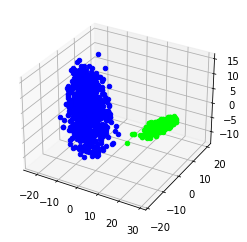

In [17]:
c = 0
red_activations = red_activations_by_class[c]
clusters = clusters_by_class[c]
fig = plt.figure()
ax = plt.axes(projection='3d')
colors=["#0000FF", "#00FF00"]
for i, act in enumerate(red_activations):
    ax.scatter3D(act[0], act[1], act[2], color = colors[clusters[i]])

Clusters for class 1.
Note that one of the clusters contains the poisonous data for this class.
Also, legitimate number of data points are less (see relative size of digits)


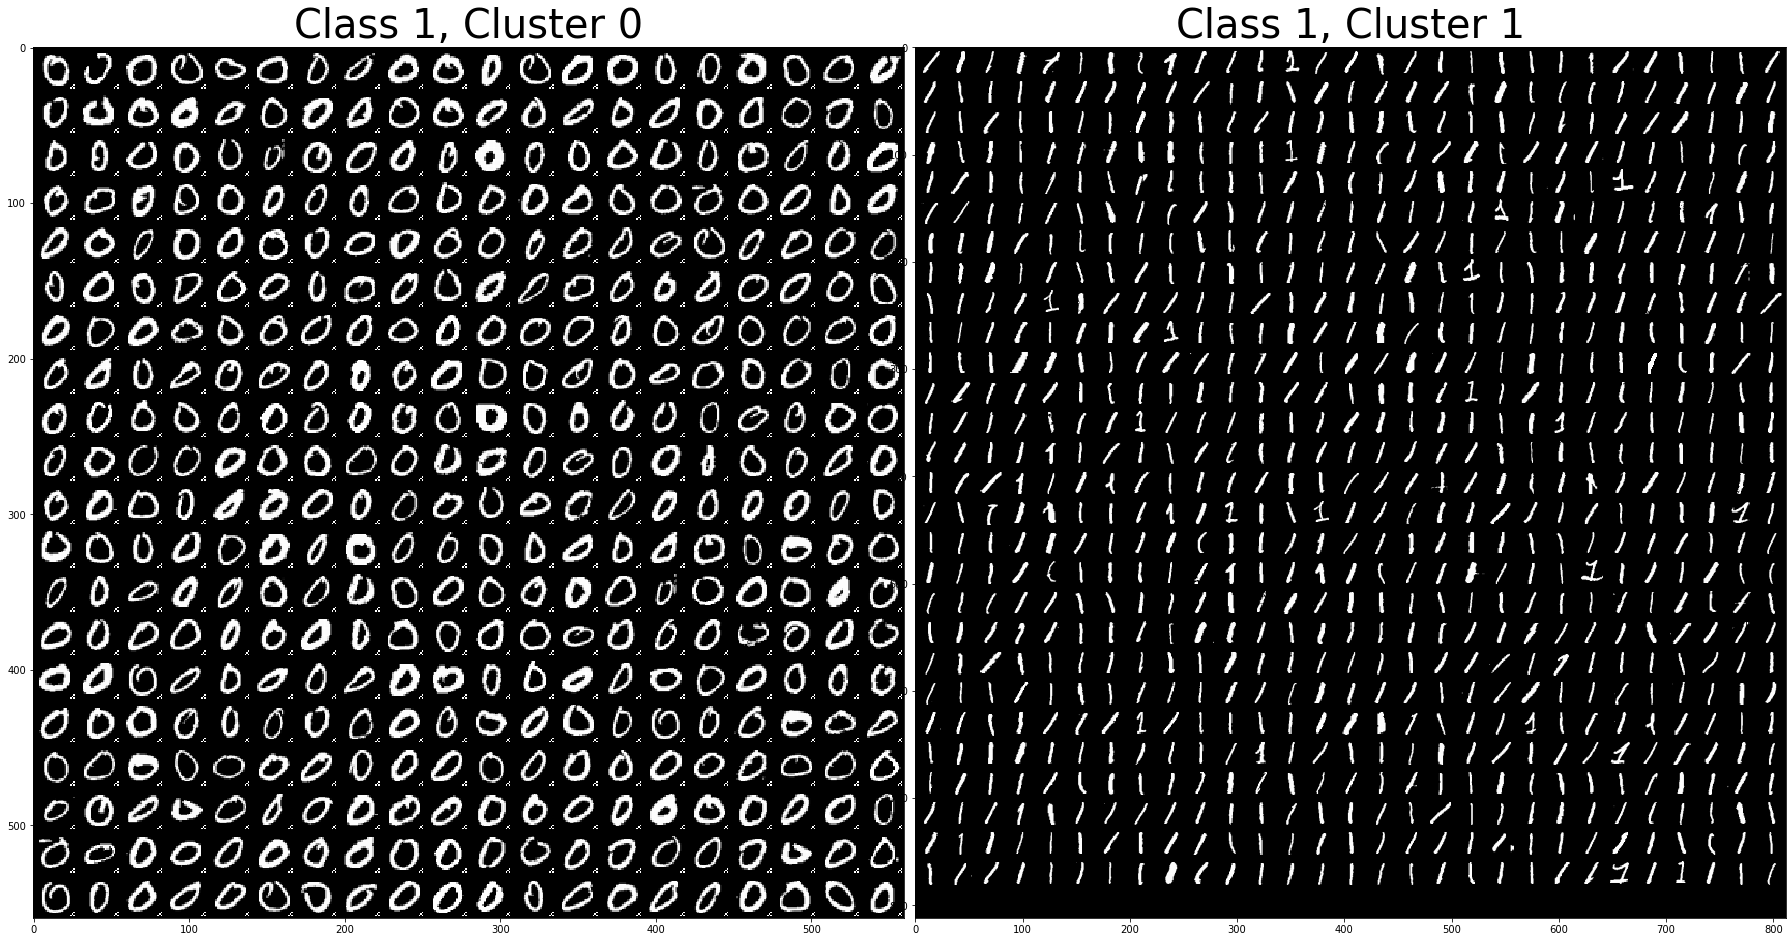

In [18]:
def plot_class_clusters(n_class, n_clusters):
    for q in range(n_clusters):
        plt.figure(1, figsize=(25, 25))
        plt.tight_layout()
        plt.subplot(1, n_clusters, q + 1)
        plt.title("Class "+ str(n_class)+ ", Cluster " + str(q), fontsize=40)
        sprite = sprites_by_class[n_class][q]
        plt.imshow(sprite, interpolation='none')
        
sprites_by_class = defence.visualize_clusters(x_train, save=False)

print("Clusters for class 1.")
print("Note that one of the clusters contains the poisonous data for this class.")
print("Also, legitimate number of data points are less (see relative size of digits)")
plot_class_clusters(1, 2)

Clusters for class 5:


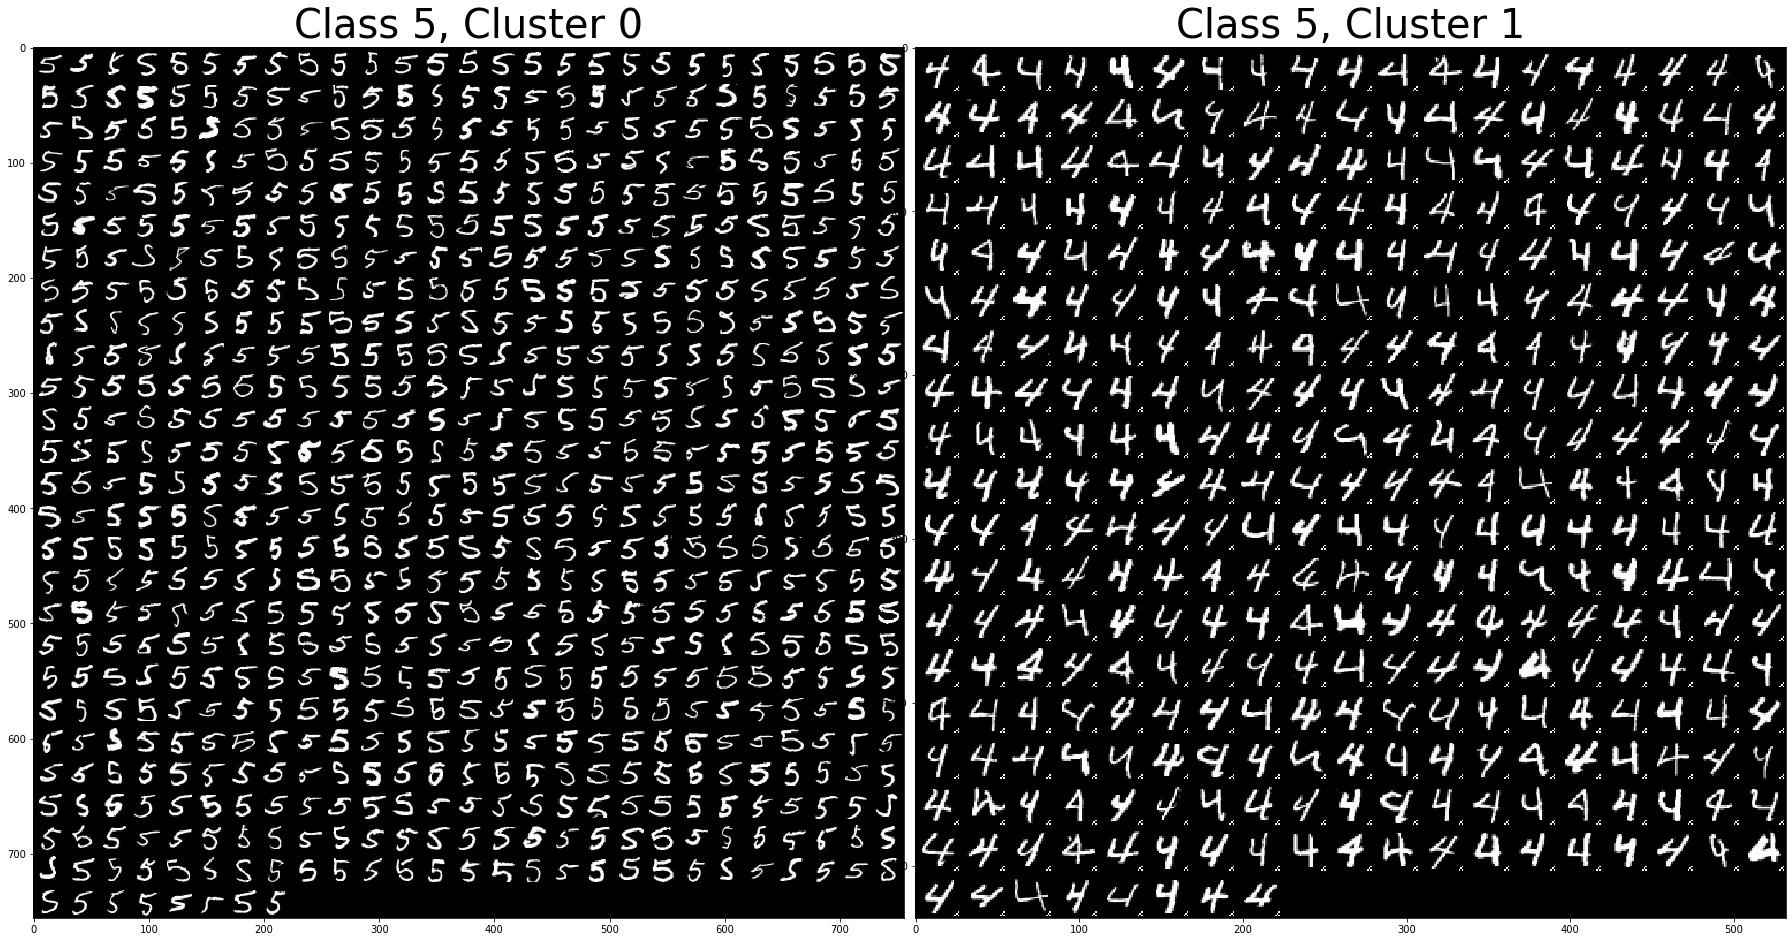

In [19]:
print("Clusters for class 5:")
plot_class_clusters(5, 2)